## Tratamiendo de los datos de SONDA

In [1]:

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import math

from helper_fn import preprocess_features, preprocess_new_features


/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Preprocesamiento de los datos

Primero, cargamos los datos desde un archivo CSV

In [2]:
oportunidades = pd.read_csv("oportunidades2.csv")
to_predict_file= pd.read_csv("Libro14.csv")
to_predict_file.drop(['Unnamed: 10'], axis=1, inplace=True)

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (1,2,4,6,9,10,14,15,17,19,20,21,22,25,27,28,30,33,34,35,36,43,44,48,49,50,54,55,56,57,61,62,63,70,72,74,78,80,89,90,91,96,97,98,100,109,111,112,119,122,124,126,127,130,133,139,140,141,144,164,171,177,201,236) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [23]:
#oportunidades.head()#[['totalamount_base', 'filialname']
#to_predict_file

La siguiente función toma el archivo ``oportunidades.csv`` y selecciona los atributos utiles para este analisis

Buscamos los dos sets de filial crm y filial no crm

In [4]:
filial_crm, filial_nocrm = preprocess_features(oportunidades)
to_predict_features = preprocess_new_features(to_predict_file)

n = len(filial_crm.columns)

filial_crm.drop(['cmtx_unidaddenegocioname', 'Duracion_dias', 'Estado_Perdido'], axis=1, inplace=True)
to_predict_features.drop(['cmtx_unidaddenegocioname'], axis=1, inplace=True)


/Users/atescobar/Development/projects/sonda/datosCompletos/helper_fn.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  selected_features['cmtx_fechacierreoportunidad'] = pd.to_datetime(selected_features['cmtx_fechacierreoportunidad'])
/Users/atescobar/Development/projects/sonda/datosCompletos/helper_fn.py:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  selected_features['createdon'] = pd.to_datetime(selected_features['createdon'])


In [25]:
#to_predict_features.dtypes

## Sets de prueba y de entrenamiento
Dividimos la muestra en prueba y entrenamiento, dejando de entrenamiento los datos del 2018. Primero trabajaremos solo con las filiales que son parte del crm, para las cuales tenemos datos de clasificación sensibles.

In [26]:

thisyear = pd.to_datetime('today').year
year_str = '1/1/'+str(thisyear)
thisyear = pd.to_datetime(year_str)
#ts = thisyear - pd.DateOffset(years=1)
ts = thisyear - pd.DateOffset(years=1)



#to_predict_features = filial_crm.loc[:, filial_crm.columns != 'Estado_Ganado'].loc[filial_crm.index > thisyear]
to_predict_id = to_predict_features['Opportunityid']
to_predict_features.drop(['Opportunityid'],axis=1, inplace=True)
to_train_features = filial_crm.loc[:, filial_crm.columns != 'Estado_Ganado'].loc[filial_crm.index <= thisyear]
to_train_target = filial_crm['Estado_Ganado'].loc[filial_crm.index <= thisyear]
to_train_features.drop(['opportunityid'],axis=1, inplace=True)



train = to_train_features
target = to_train_target


#montototal = filial_crm[['totalamount_base', 'Estado_Ganado']]
#monto = filial_crm[['totalamount_base', 'Estado_Ganado']]
#montototal = montototal.loc[montototal['Estado_Ganado'] == 1]
#montototal = montototal.loc[montototal.index >= thisyear]
#montototal = montototal.loc[montototal.index < thisyear]
#filial_crm.drop(['totalamount_base'],axis=1, inplace=True)
#montototal.drop(['Estado_Ganado'],axis=1, inplace=True)


KeyError: 'Opportunityid'

## Crear el modelo


In [7]:


def train_input_fn(features, labels, batch_size):
    """An input function for training"""
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))
    dataset = dataset.shuffle(10).repeat().batch(batch_size)
    return dataset




def eval_input_fn(features, labels, batch_size):
    """An input function for evaluation or prediction"""
    features=dict(features)
    if labels is None:
        inputs = features
    else:
        inputs = (features, labels)

    dataset = tf.data.Dataset.from_tensor_slices(inputs)
    
    assert batch_size is not None, "batch_size must not be None"
    dataset = dataset.batch(batch_size)

    return dataset



In [8]:
feature_columns = []

for key in train.keys():
    feature_columns.append(tf.feature_column.numeric_column(key=key))


In [9]:
classifier = tf.estimator.DNNClassifier(
    feature_columns=feature_columns,
    hidden_units=[2*n+1 ,],
    n_classes=2,
    )

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/gw/mpmkzqcs0wq9b37znq_nz9f00000gn/T/tmpom_s9x6m', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1a22349320>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


# Train the model

In [10]:
batch_size = 100
train_steps = 500
 
classifier.train(input_fn = lambda: train_input_fn(train, target, batch_size), steps = train_steps)
#eval_result = classifier.evaluate(input_fn = lambda: eval_input_fn(to_predict_features, None,batch_size))
#print(eval_result)

#accuracy_score = classifier.evaluate(input_fn=lambda:eval_input_fn(features_test,labels=target_test,batch_size=batch_size))['accuracy']
#print('\nTest Accuracy: {0:f}%\n'.format(accuracy_score*100))


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/gw/mpmkzqcs0wq9b37znq_nz9f00000gn/T/tmpom_s9x6m/model.ckpt.
INFO:tensorflow:loss = 23060881000.0, step = 1
INFO:tensorflow:global_step/sec: 373.532
INFO:tensorflow:loss = 191434580.0, step = 101 (0.269 sec)
INFO:tensorflow:global_step/sec: 604.131
INFO:tensorflow:loss = 7606705.5, step = 201 (0.166 sec)
INFO:tensorflow:global_step/sec: 544.218
INFO:tensorflow:loss = 33935544.0, step = 301 (0.184 sec)
INFO:tensorflow:global_step/sec: 514.837
INFO:tensorflow:loss = 393354270.0, step = 401 (0.194 sec)
INFO:tensorflow:Saving checkpoints for 500 into /var/folders/gw/mpmkzqcs0wq9b37znq_nz9f00000gn/T/tmpom_s9x6m/model.ckpt.
INFO:tensorflow:Loss for final step: 2577983000.0.


# Predicciones

Ahora vemos como se comporta en la predicción de cierre de oportunidad

In [11]:

predictions = classifier.predict(input_fn=lambda:eval_input_fn(to_predict_features,labels=None, batch_size=batch_size))

template = ('\nPrediction is {} with ({:.1f}%) probability')

val = []
val2 = []
val3 = []
for pred_dict in predictions:
    class_id = pred_dict['class_ids'][0] 
    if(class_id==0):
        probability = 1-pred_dict['probabilities'][class_id]
    if(class_id==1):
        probability = pred_dict['probabilities'][class_id]
    val2.append(class_id)
    val3.append(probability)
    
    #print(template.format(class_id, 100 * probability))

print("\nPredictions stored in array val")


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/gw/mpmkzqcs0wq9b37znq_nz9f00000gn/T/tmpom_s9x6m/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.

Predictions stored in array val


In [12]:
val1 = to_predict_id.as_matrix()

df = pd.DataFrame({'opt_id': val1, 'class_id': val2, 'prob':val3})
df['opt_id'] = df['opt_id'].astype(int)
df = df.set_index('opt_id')
df.to_csv('results.csv')

df

,class_id,prob
opt_id,,
202219,0,0.470592
212552,1,1.000000
210768,1,1.000000
215400,1,1.000000
215930,0,0.470592
214446,1,1.000000
210592,1,1.000000
219183,1,1.000000
219235,1,1.000000


In [13]:
def get_opt_prob_by_id(id_num):
    df = pd.read_csv('results.csv')
    df = df.set_index('opt_id')
    
    ret = df.loc[df.index == id_num].as_matrix()

    return ret[0]

#df['totalamount_base'].loc[df['class_id'] == 1].sum()



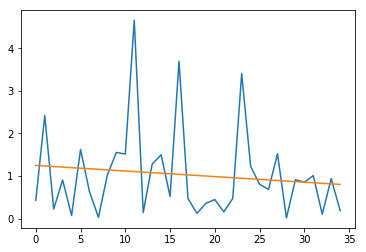

6.632551610465121
8.606976947994479


In [14]:
from scipy import stats
import numpy as np

def lin_reg(x, slope, intercept):
    y = slope * x + intercept
    return y

y = filial_nocrm['totalamount_base'].as_matrix()
x = np.arange(len(y))

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

plt.plot(x,y)
plt.plot(x,lin_reg(x, slope, intercept))
plt.show()

x_q3 = np.arange(len(y),len(y)+9)
x_q4 = np.arange(len(y),len(y)+12)
y_q3 = lin_reg(x_q3, slope, intercept).sum()
y_q4 = lin_reg(x_q4, slope, intercept).sum()
proyeccion_q3 = y_q3
proyeccion_q4 = y_q4


print(proyeccion_q3)
print(proyeccion_q4)


In [15]:
#cerrado = montototal.sum()/1e10


In [16]:
#cerrado + proyeccion_anual